In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from pygimli.physics import TravelTimeManager
import pygimli.physics.traveltime as tt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.core.interpolation import ProfileInterpolator, create_surface_lines
from PyHydroGeophysX.core.mesh_utils import MeshCreator
from PyHydroGeophysX.petrophysics.resistivity_models import water_content_to_resistivity
from PyHydroGeophysX.petrophysics.velocity_models import HertzMindlinModel, DEMModel



In [2]:
output_dir = "results/SRT_forward"
os.makedirs(output_dir, exist_ok=True)

## 1. Follow the workflow to create the mesh and model

In [4]:


# These would be your actual data files
data_dir = "data/"
modflow_dir = os.path.join(data_dir, "modflow")

# Load domain information from files
# (Replace with your actual file paths)
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))

Water_Content = np.load(os.path.join(data_dir, "Watercontent.npy"))

water_content = Water_Content[50]
print(water_content.shape)


# Step 3: Set up profile for 2D section

# Define profile endpoints
point1 = [115, 70]  # [col, row]
point2 = [95, 180]  # [col, row]

# Initialize profile interpolator
interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.2983333333,
    origin_y=4842444.17,
    pixel_width=1.0,
    pixel_height=-1.0,
    num_points = 400
)



# Interpolate water content to profile
water_content_profile = interpolator.interpolate_3d_data(water_content)

# Interpolate porosity to profile
porosity_profile = interpolator.interpolate_3d_data(porosity)

(14, 194, 157)


## Creating geometry for the seismic refraction survey

In [ ]:


# Load structure layers
bot = np.load(os.path.join(data_dir, "bot.npy"))

# Process layers to get structure
structure = interpolator.interpolate_layer_data([top] + bot.tolist())

# Create surface lines
# Indicate the layer for the structure regolith, fractured bedrock and fresh bedrock
top_idx=int(0)
mid_idx=int(4)
bot_idx=int(13)
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=top_idx,
    mid_idx=mid_idx,
    bot_idx=bot_idx
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth= np.min(line2[:,1]) - 10 #50.0
)

## Interpolating data to mesh

In [281]:

# marker labels for the layers
marker_labels = [0, 3, 2] # top. mid, bottom layers (example values)
# assign the values for the regolith and fractured bedrock
ID1 = porosity_profile.copy()
ID1[:mid_idx] = marker_labels[0] #regolith
ID1[mid_idx:] = marker_labels[1] # fractured bedrock


# Get mesh centers and markers
mesh_centers = np.array(mesh.cellCenters())
mesh_markers = np.array(mesh.cellMarkers())
porosity_mesh = np.zeros_like(mesh_markers, dtype=float)
wc_mesh = np.zeros_like(mesh_markers, dtype=float)
for i in range(len(marker_labels)):
    if i == 2:
        # assign the values for the fresh bedrock, since fresh bedrock is no flux boundary and assume the homogeneous as the last layer
        ID1[bot_idx] = marker_labels[2] # fractured bedrock # fresh bedrock
    # Interpolate porosity to mesh
    porosity_temp = interpolator.interpolate_to_mesh(
        property_values=porosity_profile,
        depth_values=structure,
        mesh_x=mesh_centers[:, 0],
        mesh_y=mesh_centers[:, 1],
        mesh_markers=mesh_markers,
        ID=ID1, # Use ID1 to indicate the layers for interpolation
        layer_markers = [marker_labels[i]],

    )

    porosity_mesh[mesh_markers==marker_labels[i]] = porosity_temp[mesh_markers==marker_labels[i]]

    # Interpolate water content to mesh
    wc_temp = interpolator.interpolate_to_mesh(
        property_values=water_content_profile,
        depth_values=structure,
        mesh_x=mesh_centers[:, 0],
        mesh_y=mesh_centers[:, 1],
        mesh_markers=mesh_markers,
        ID=ID1, # Use ID1 to indicate the layers for interpolation
        layer_markers = [marker_labels[i]],
    )
    wc_mesh[mesh_markers==marker_labels[i]] = wc_temp[mesh_markers==marker_labels[i]]




saturation = wc_mesh / porosity_mesh

## Convert to P wave velocity using petrophysical model

In [326]:


# Initialize velocity models
hm_model = HertzMindlinModel(critical_porosity=0.4, coordination_number=6.0)
dem_model = DEMModel()

# Initialize velocity model
velocity_mesh = np.zeros_like(wc_mesh)


top_mask = (mesh_markers == marker_labels[0])
top_bulk_modulus = 30.0  # GPa
top_shear_modulus = 20.0  # GPa
top_mineral_density = 2650  # kg/m³
top_depth = 1.0  # m

# Get Vp values using Hertz-Mindlin model
Vp_high, Vp_low = hm_model.calculate_velocity(
    porosity=porosity_mesh[top_mask],
    saturation=saturation[top_mask],
    bulk_modulus=top_bulk_modulus,
    shear_modulus=top_shear_modulus,
    mineral_density=top_mineral_density,
    depth=top_depth
)

# Use average of high and low bounds
velocity_mesh[top_mask] = (Vp_high + Vp_low) / 2



mid_mask = (mesh_markers == marker_labels[1])

mid_bulk_modulus = 45.0  # GPa
mid_shear_modulus = 35.0 # GPa
mid_mineral_density = 2670  # kg/m³
mid_aspect_ratio = 0.05

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[mid_mask],
    saturation=saturation[mid_mask],
    bulk_modulus=mid_bulk_modulus,
    shear_modulus=mid_shear_modulus,
    mineral_density=mid_mineral_density,
    aspect_ratio=mid_aspect_ratio
)

velocity_mesh[mid_mask] = Vp

bot_mask = (mesh_markers == marker_labels[2])
bot_bulk_modulus = 55  # GPa
bot_shear_modulus = 50  # GPa
bot_mineral_density = 2700 # kg/m³
bot_aspect_ratio = 0.04

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[bot_mask],
    saturation=saturation[bot_mask],
    bulk_modulus=bot_bulk_modulus,
    shear_modulus=bot_shear_modulus,
    mineral_density=bot_mineral_density,
    aspect_ratio=bot_aspect_ratio
)

velocity_mesh[bot_mask] = Vp

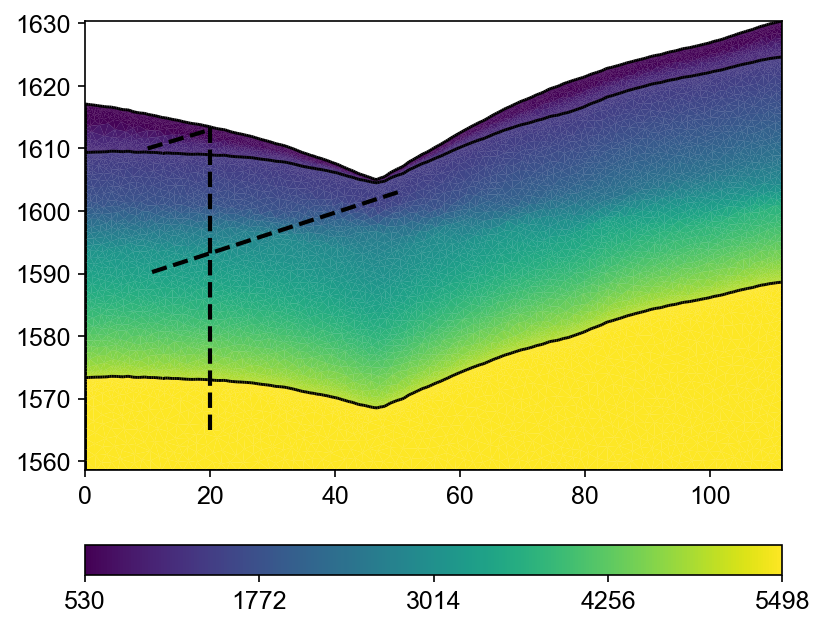

In [329]:
ax,cbar = pg.show(mesh,velocity_mesh)
ax.plot([20, 20], [1565, 1614], 'k--', lw=2)

ax.plot([10, 20], [1610, 1613], 'k--', lw=2)

ax.plot([50,10], [1603, 1590], 'k--', lw=2)

In [322]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pygimli as pg

# Font settings for publication
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.dpi'] = 150


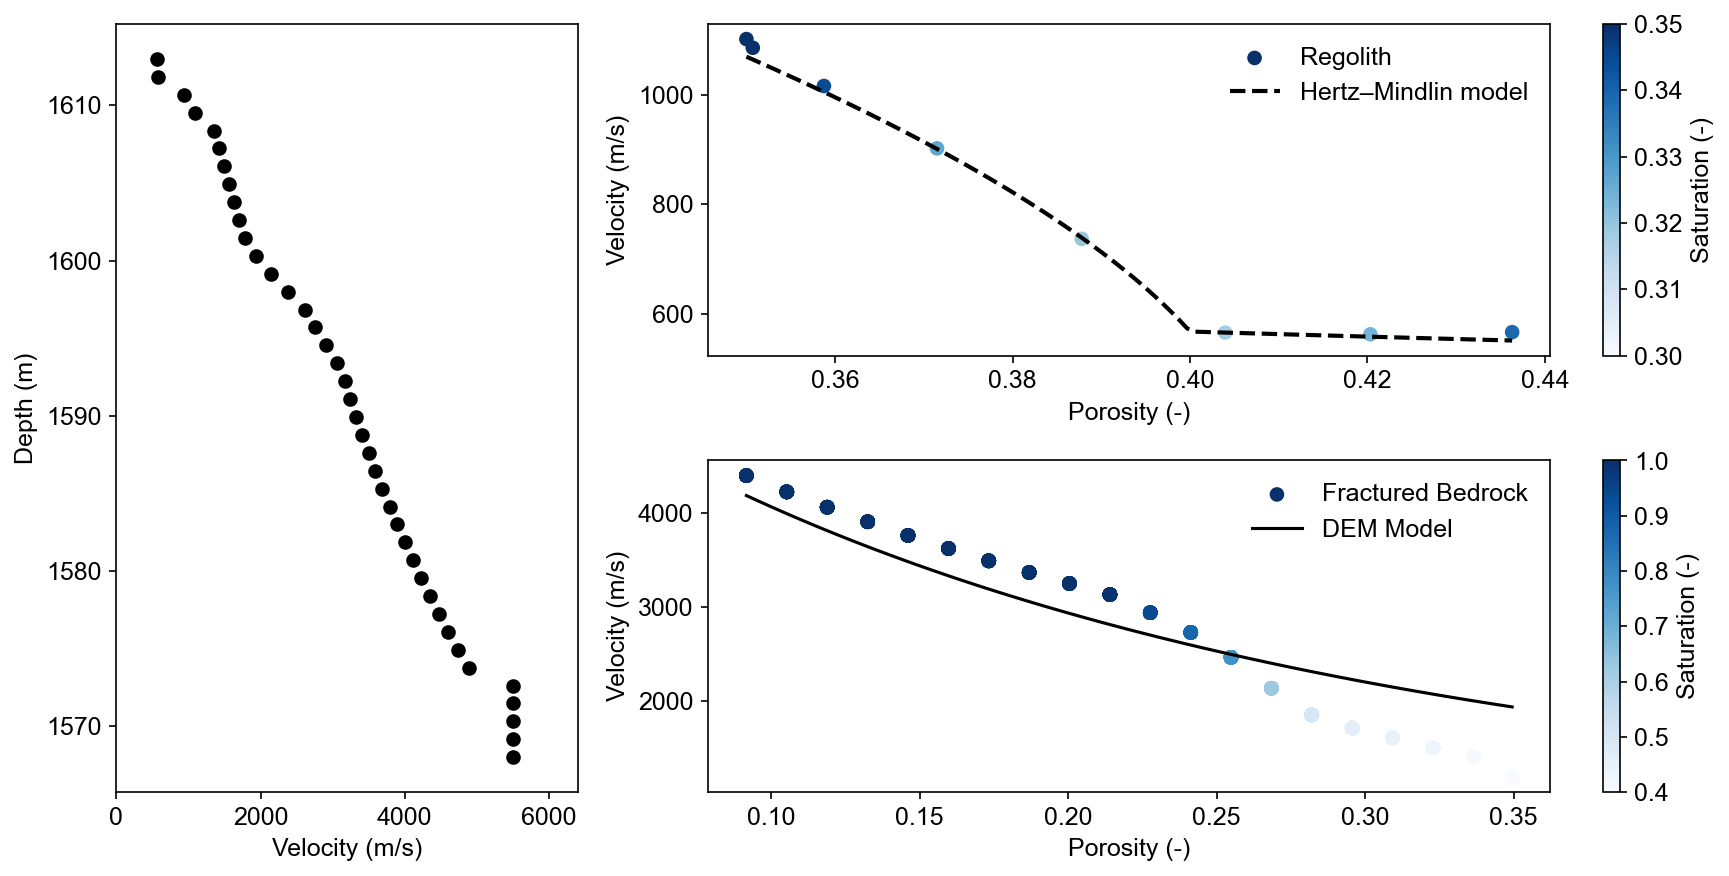

In [330]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

# First interpolation for the main plot
x1, y1 = np.mgrid[20:21:1j, 1568:1613:40j]
vel = griddata(mesh_centers[:,0:2], velocity_mesh, (x1, y1), method='linear')
po = griddata(mesh_centers[:,0:2], porosity_mesh, (x1, y1), method='linear')

plt.figure(figsize=(12, 6))

# First subplot - narrower left side (spans both rows, 1 column)
plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=1)
plt.scatter(vel.ravel(), y1.ravel(), c='k')
plt.xlim([0, 6400])
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')

# Second subplot - larger top right position (spans 2 columns)
plt.subplot2grid((2, 3), (0, 1), colspan=2)

# Second interpolation
x1, y1 = np.mgrid[20:21:1j, 1609.2:1613:8j]
vel_1 = griddata(mesh_centers[:,0:2], velocity_mesh, (x1, y1), method='linear')
po_1 = griddata(mesh_centers[:,0:2], porosity_mesh, (x1, y1), method='linear')
sat_1 = griddata(mesh_centers[:,0:2], saturation, (x1, y1), method='linear')

Vp_high, Vp_low = hm_model.calculate_velocity(
    porosity=np.linspace(np.nanmin(po_1.ravel()), np.nanmax(po_1.ravel()), 100),
    saturation=np.ones(100)*np.nanmin(sat_1.ravel()),
    bulk_modulus=top_bulk_modulus,
    shear_modulus=top_shear_modulus,
    mineral_density=top_mineral_density,
    depth=top_depth)

plt.scatter(po_1.ravel(), vel_1.ravel(), c=sat_1.ravel(), vmin=0.30, vmax=0.35, cmap='Blues',label='Regolith')
plt.colorbar(label='Saturation (-)')
plt.plot(np.linspace(np.nanmin(po_1.ravel()), np.nanmax(po_1.ravel()), 100), 
         (Vp_high + Vp_low) / 2, 'k--', lw=2,label='Hertz–Mindlin model')
plt.legend(frameon=False)
plt.xlabel('Porosity (-)')
plt.ylabel('Velocity (m/s)')

# Third subplot - larger bottom right position (spans 2 columns)
plt.subplot2grid((2, 3), (1, 1), colspan=2)

# Third interpolation
x1, y1 = np.mgrid[20:20:20j, 1578:1609:20j]
vel_2 = griddata(mesh_centers[:,0:2], velocity_mesh, (x1, y1), method='linear')
po_2 = griddata(mesh_centers[:,0:2], porosity_mesh, (x1, y1), method='linear')
sat_2 = griddata(mesh_centers[:,0:2], saturation, (x1, y1), method='linear')

# Get Vp values using DEM model
_, _, Vp_minsat = dem_model.calculate_velocity(
    porosity = np.linspace(np.nanmin(po_2.ravel()), np.nanmax(po_2.ravel()), 100),
    saturation=np.ones(100)*np.nanmean(sat_2.ravel()),
    bulk_modulus=mid_bulk_modulus,
    shear_modulus=mid_shear_modulus,
    mineral_density=mid_mineral_density,
    aspect_ratio=mid_aspect_ratio
)

plt.scatter(po_2.ravel(), vel_2.ravel(), c=sat_2.ravel(), cmap='Blues', vmin=0.4, vmax=1,label='Fractured Bedrock')
plt.plot(np.linspace(np.nanmin(po_2.ravel()), np.nanmax(po_2.ravel()), 100),Vp_minsat,label='DEM Model',c='k')
plt.legend(frameon=False)
plt.xlabel('Porosity (-)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Saturation (-)')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "velocity_porosity_saturation.tiff"), dpi=300, bbox_inches='tight')

## Short distance seismic survey

In [ ]:
################## Seismic data #####################

print("Step 11: Creating seismic survey design...")

numberGeophones = 72
shotDistance = 5
sensors = np.linspace(15,15 + 72 - 1, numberGeophones)
scheme = pg.physics.traveltime.createRAData(sensors,shotDistance=shotDistance)



for i in range(numberGeophones):
    minusx = np.abs(surface[:,0]-sensors[i])
    index = np.where(minusx== np.amin(minusx))
    new_x = surface[index,0]
    new_y = surface[index,1]
    pos[i, 0] = new_x
    pos[i, 1] = new_y


scheme.setSensors(pos)


mgr = TravelTimeManager()
datasrt = mgr.simulate(slowness=1.0 / velocity_mesh, scheme=scheme, mesh=mesh,
                    noiseLevel=0.05, noiseAbs=0.00001, seed=1334
                    ,verbose=True)
datasrt.save(os.path.join(output_dir, "synthetic_seismic_data.dat"))